# AG4 - Actividad Guiada 4 - Algoritmos Genéticos

Nombre: Carlos Javier Bravo Intriago

Link:   https://colab.research.google.com/drive/18FHxc4yPpLlYE86Gjui10spmff-DP73P?usp=sharing

Github: https://github.com/carlosbravo1408/03MIAR-Algoritmos-de-Optimizacion-2025/tree/main/AG4


# Carga de librerias

In [1]:
!pip install requests
!pip install tabulate>=0.9 networkx>=3.0
!pip install tsplib95 --no-deps
!pip install deprecated


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


# Importe de librerias


In [2]:
import os
import gzip
import math
import random
import shutil
import urllib.request
from IPython.display import HTML
from typing import Union, Tuple, List, Literal

import matplotlib.pyplot as plt

import tsplib95

## Métodos Auxiliares y algunas definiciones necesarias


In [3]:
NumericType = Union[int, float]
NodeType = int
EdgeType = Tuple[NodeType, NodeType]
SolutionType = List[NodeType]
TSProblemType = tsplib95.models.Problem


def download_tsp_file(url: str, filename: str) -> None:
    # Descarga como archivo temporal
    local_path, headers = urllib.request.urlretrieve(url, filename + ".temp")
    mime_type = headers.get_content_type()
    # Descomprimir si es formato gzip
    if "gzip" in mime_type or local_path.endswith(".gz"):
        with gzip.open(local_path, 'rb') as f_in:
            with open(filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove(local_path)
    # Caso contrario renombra el archivo temporal
    else:
        os.replace(local_path, filename)

# Carga de datos del problema

In [4]:
#DATOS DEL PROBLEMA
# Matriz Adyacencia swiss42 problem (Staedte Schweiz/Fricker)
file = "swiss42.tsp"
download_tsp_file(
    "https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/swiss42.tsp",
    file)
tsp_problem: tsplib95.models.Problem = tsplib95.load(file)

# Lo siguiente NO es una buena práctica de programacion y hay gente que
# considera sucia, pero permite optimizar algo más el código. Se inyecta la
# lista de nodos en el objeto tsp_problem, con ello se evita crear una nueva
# lista cada vez que se invoca a `get_nodes()`
tsp_problem.cached_nodes = list(tsp_problem.get_nodes())

#Nodos
nodes = tsp_problem.cached_nodes

# Funciones básicas
> Funciones de la Actividad Guiada 3

In [5]:
def crear_solucion(nodos: List[NodeType]) -> SolutionType:
    """
    Se genera una solución aleatoria con comienzo en el nodo 0
    :param nodos: Lista de nodos
    :return: Lista de nodos en posiciones aleatorias sin repetición
    """
    return random.sample(nodos, len(nodos))

def distancia(a: int, b: int, problem: TSProblemType) -> NumericType:
    """
    Devuelve la distancia entre dos nodos
    :param a: Nodo a
    :param b: Nodo b
    :param problem: Instancia de tsplib95.models.Problem
    :return:
    """
    return problem.get_weight(a, b)

def distancia_total(solucion: SolutionType, problem: TSProblemType) -> NumericType:
    """
    Devuelve la distancia total de una trayectoria/solución
    :param solucion: Lista de Nodos
    :param problem: Instancia de tsplib95.models.Problem
    :return:
    """
    distancia_total = 0
    n = len(solucion)
    for i in range(len(solucion)):
        distancia_total += distancia(solucion[i], solucion[(i + 1)%n], problem)
    return distancia_total

def validar_solucion(solucion: SolutionType, problem: TSProblemType) -> bool:
    """
    Método que retorna `True` en el caso de que la solución sea válida (no
    hay repetidos, ni elementos faltantes), caso contrario arroja `False`
    :param solucion:
    :param problem:
    :return:
    """
    return set(solucion) == set(problem.cached_nodes)


distancia_total(crear_solucion(nodes), tsp_problem)

4946

# Funciones Auxiliares

In [6]:
def generar_poblacion(problem:TSProblemType, N: int) -> List[SolutionType]:
    """
    Genera una poblacion inicial de soluciones de tamaño N.
    Se propone generar un 85% de poblacion aleatoria, y el 15% restante una
    poblacion voraz, con una predisposición a tener mejor gen con respecto a
    sus contrapartes generadas aleatoriamente.

    Inspirado del paper propuesto como material bibliográfico en clases
    https://indjst.org/articles/solving-travelling-salesman-problem-using-improved-genetic-algorithm,
    el cual el Autor propone la generación de cromosomas de manera Voraz,
    para este caso se generó un 15% de la poblacion inicial utilizando
    una estrategia constructiva voraz (Vecino más cercano) con la finalidad
    de agregar individuos genéticos más aptos, mientras que el 85% restante
    se generó de forma puramente aleatoria. Esta estrategia y esta proporción
    asignada promete una convergencia más rápida sin sacrificar la entropia
    necesaria para evitar estancamientos en optimos locales antes de tiempo.
    :param problem:
    :param N:
    :return:
    """
    nodos = problem.cached_nodes
    poblacion = []
    nodos_vistos = set()
    semilla = min(math.ceil(N * 0.15), len(nodos))
    poblacion.extend(generar_poblacion_voraz(problem, semilla))
    _ = [nodos_vistos.add(tuple(individuo)) for individuo in poblacion]
    while len(poblacion) < N:
        # Evitar duplicados, se debe procurar que en la generacion de
        # poblacion no haya individuos genéticamente iguales (comparación
        # rápida y amortizado lineal es con Tuplas y Set)
        individuo = tuple(random.sample(nodos, len(nodos)))
        if individuo not in nodos_vistos:
            nodos_vistos.add(individuo)
            poblacion.append(list(individuo))
    return poblacion

def generar_poblacion_voraz(problem: TSProblemType, N: int) -> List[SolutionType]:
    """
    Genera una poblacion usando una estrategia voraz para encontrar el vecino
    más cercano.
    :param problem:
    :param N:
    :return:
    """
    # TODO: Limpiar o refactorizar este método
    nodos = problem.cached_nodes
    nodos_iniciales = random.sample(nodos, min(N, len(nodos)))
    poblacion = []
    individuos_vistos = set()
    for nodo_inicial in nodos_iniciales:
        individuo = [nodo_inicial]
        no_visitados = set(nodos)
        no_visitados.remove(nodo_inicial)
        nodo_actual = nodo_inicial
        while no_visitados:
            siguiente_nodo = min(
                no_visitados,
                key=lambda candidato: distancia(nodo_actual, candidato, problem)
            )
            individuo.append(siguiente_nodo)
            no_visitados.remove(siguiente_nodo)
            nodo_actual = siguiente_nodo

        individuo = tuple(individuo)
        if individuo not in individuos_vistos:
            individuos_vistos.add(individuo)
            poblacion.append(list(individuo))
    return poblacion

poblacion_prueba = generar_poblacion(tsp_problem, 50)
assert validar_solucion(poblacion_prueba[0], tsp_problem)
_ = [print(p) for p in poblacion_prueba[:5]]

[15, 14, 16, 37, 17, 31, 7, 1, 0, 3, 2, 27, 28, 29, 30, 32, 34, 20, 33, 35, 36, 6, 4, 26, 5, 19, 13, 18, 12, 11, 25, 10, 8, 9, 23, 41, 21, 39, 22, 38, 24, 40]
[31, 17, 37, 15, 14, 16, 19, 13, 5, 26, 18, 12, 11, 25, 10, 8, 9, 23, 41, 29, 30, 28, 2, 27, 3, 4, 6, 1, 0, 7, 32, 34, 20, 33, 35, 36, 38, 22, 39, 21, 40, 24]
[16, 14, 15, 37, 17, 31, 7, 1, 0, 3, 2, 27, 28, 29, 30, 32, 34, 20, 33, 35, 36, 6, 4, 26, 5, 19, 13, 18, 12, 11, 25, 10, 8, 9, 23, 41, 21, 39, 22, 38, 24, 40]
[3, 2, 27, 28, 29, 30, 32, 0, 1, 6, 4, 26, 5, 19, 13, 18, 12, 11, 25, 10, 8, 9, 23, 41, 21, 39, 22, 38, 34, 20, 33, 31, 17, 37, 15, 14, 16, 7, 36, 35, 40, 24]
[33, 20, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 22, 38, 39, 21, 40, 24, 9, 23, 41, 25, 10, 8, 12, 11, 18, 26, 5, 19, 13, 14, 16, 15, 37, 17, 31, 7, 36, 35]


In [7]:
def Evaluar_Poblacion(
        poblacion: List[SolutionType],
        problem: TSProblemType
) -> Tuple[SolutionType, NumericType]:
    """
    Evalúa la población y devuelve el mejor individuo.\n
    Ingenuamente retorna el individuo con menor coste.
    :param poblacion:
    :param problem:
    :return:
    """
    sol = min(poblacion, key=lambda s: distancia_total(s, problem))
    dist = distancia_total(sol, problem)
    return sol, dist

_ = Evaluar_Poblacion(poblacion_prueba, tsp_problem)

In [8]:
def Factibilizar(
        solucion: SolutionType,
        problem: TSProblemType,
        puntos_corte: List[int]
) -> SolutionType:
    """
    Para el operador de cruce 1-punto los hijos generados no son soluciones
    (algunos nodos se repiten y otros no están)\n
    Método que verifica y corrige aquellos hijos generados en el cruce.
    :param solucion:
    :param problem:
    :param puntos_corte:
    :return:
    """
    n = len(solucion)
    _solucion = list(solucion)
    all_nodes = set(problem.cached_nodes)
    faltantes = list(all_nodes - set(_solucion))
    random.shuffle(faltantes)
    start = puntos_corte[0]
    if len(puntos_corte) == 1:
        end = n
    else:
        end = puntos_corte[1]
    auxiliar = set(_solucion[:start] + _solucion[end:])
    for i in range(start, end):
        nodo_actual = _solucion[i]
        if nodo_actual in auxiliar:
            _solucion[i] = faltantes.pop()
        else:
            auxiliar.add(nodo_actual)
    if not validar_solucion(_solucion, problem):
        raise ValueError("Fallo en la Factibilización")
    return _solucion


In [9]:
def Mutar(solucion: SolutionType, mutacion: float):
    """
    Función de mutación. Se eligen dos nodos y se intercambia. Se podrían
    añadir otros operadores\n
    Se hace mutaciones mutación % de las veces
    :param solucion:
    :param mutacion:
    :return:
    """
    _solution = list(solucion)
    if random.random() <= mutacion:
        i, j = sorted(random.sample(range(0, len(solucion)), 2))
        _solution[i], _solution[j] = _solution[j], _solution[i]
    return _solution

In [10]:
def Descendencia(
        padres: Tuple[SolutionType, SolutionType],
        problem: TSProblemType,
        mutacion: float,
        estrategia_cruce: Literal["1-point", "2-point"] = "2-point"
) -> Tuple[SolutionType, SolutionType]:
    """
    Función para generar hijos a partir de 2 padres:
    Se elige el método de 1-punto o 2-puntos de cortes. Por defecto
    "2-point"
    :param padres:
    :param problem:
    :param mutacion:
    :param estrategia_cruce:
    :return:
    """
    padre_a = padres[0]
    padre_b = padres[1]
    n = len(problem.cached_nodes)
    num_cortes = 2 if estrategia_cruce == "2-point" else 1
    puntos_corte = sorted(random.sample(range(1, n), num_cortes))

    # division
    if len(puntos_corte) == 1:
        hijo_a = padre_a[:puntos_corte[0]] + padre_b[puntos_corte[0]:]
        hijo_b = padre_b[:puntos_corte[0]] + padre_a[puntos_corte[0]:]
    else:
        hijo_a = padre_a[:puntos_corte[0]] \
                 + padre_b[puntos_corte[0]:puntos_corte[1]] \
                 + padre_a[puntos_corte[1]:]
        hijo_b = padre_b[:puntos_corte[0]] \
                 + padre_a[puntos_corte[0]:puntos_corte[1]] \
                 + padre_b[puntos_corte[1]:]

    # factibilizar
    hijo_a = Factibilizar(hijo_a, problem, puntos_corte)
    hijo_b = Factibilizar(hijo_b, problem, puntos_corte)

    # mutar
    hijo_a = Mutar(hijo_a, mutacion)
    hijo_b = Mutar(hijo_b, mutacion)

    return hijo_a, hijo_b

s1, s2 = Descendencia(
    (poblacion_prueba[0], poblacion_prueba[1]), tsp_problem, 0.1, "2-point"
)


In [11]:
def Cruzar(
        poblacion: List[SolutionType],
        mutacion: float,
        problem: TSProblemType
) -> List[SolutionType]:
    """
    Función de cruce. Recibe una población (lista de soluciones) y devuelve la
    población ampliada con los hijos.\n
    Todos los individuos de la población son seleccionados para el cruce(si
    la población es par)\n
    Podría aplicarse un proceso previo de selección para elegir los
    individuos que se desea cruzar.
    :param poblacion:
    :param mutacion:
    :param problem:
    :return:
    """
    # recorrer solo los N primeros descendientes, los posteriores a encolar
    # tienden a ser los hijos
    n_padres = len(poblacion)
    _poblacion = list(poblacion)
    # se baraja la poblacion para garantizar un par de padres aleatorios.
    random.shuffle(_poblacion)
    for i in range(0, n_padres, 2):
        hijo_a, hijo_b = Descendencia(
            padres=(_poblacion[i], _poblacion[(i + 1) % n_padres]),
            mutacion=mutacion,
            problem=problem,
            estrategia_cruce="2-point"
        )
        poblacion.append(hijo_a)
        poblacion.append(hijo_b)

    return poblacion

cruce = Cruzar(poblacion_prueba, .15, tsp_problem)


In [12]:
def Seleccionar(
        problem: TSProblemType,
        poblacion: List[SolutionType],
        N: int,
        elitismo: float
):
    """
     Función de selección de la población. Recibe como parametro una
     poblacion y devuelve una poblacion a la que se ha eliminado individuos
     poco aptos(fitness alto) y para mantener una poblacion estable de N
     individuos\n
     Se tiene en cuenta el porcentaje elitismo pasado como parametro
     Para los individuos que no son de la elite podríamos usar una selección
     de ruleta(proporcional a su fitness)
    :param problem:
    :param poblacion:
    :param N:
    :param elitismo:
    :return:
    """
    _poblacion = sorted(poblacion, key=lambda x: distancia_total(x, problem))
    n_elitista = math.ceil(N*elitismo)
    nueva_poblacion = _poblacion[:n_elitista]
    individuos_restantes = _poblacion[n_elitista:]
    while len(nueva_poblacion) < N:
        # Se ha elegido la selección por torneo de 5 individuos
        participantes = random.sample(individuos_restantes, min(5, len(individuos_restantes)))
        # sobreviviente será agregado a la nueva poblacion
        ganador = min(participantes, key=lambda x: distancia_total(x, problem))
        nueva_poblacion.append(ganador)
        # removemos al ganador de la lista de individuos restantes, para asi
        # permitir a los otros participantes la posibilidad de volver a
        # participar
        individuos_restantes.remove(ganador)

    return nueva_poblacion

seleccion = Seleccionar(tsp_problem, cruce, 50, .1)

# Proceso Principal

Generación # 0 
La mejor solución es: [33, 20, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 22, 38, 39, 21, 40, 24, 9, 23, 41, 25, 10, 8, 12, 11, 18, 26, 5, 19, 13, 14, 16, 15, 37, 17, 31, 7, 36, 35] 
con distancia  1437 

Generación # 1 
La mejor solución es: [33, 20, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 22, 38, 39, 21, 40, 24, 9, 23, 41, 25, 10, 8, 12, 11, 18, 26, 5, 19, 13, 14, 16, 15, 37, 17, 31, 7, 36, 35] 
con distancia  1437 

Generación # 2 
La mejor solución es: [33, 20, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 22, 38, 39, 21, 40, 24, 9, 23, 41, 25, 10, 8, 12, 11, 18, 26, 5, 19, 13, 14, 16, 15, 37, 17, 31, 7, 36, 35] 
con distancia  1437 

Generación # 3 
La mejor solución es: [33, 20, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 22, 38, 39, 21, 40, 24, 9, 23, 41, 25, 10, 8, 12, 11, 18, 26, 5, 19, 13, 14, 16, 15, 37, 17, 31, 7, 36, 35] 
con distancia  1437 

Generación # 4 
La mejor solución es: [33, 20, 34, 32, 0, 1, 6, 4, 3, 2, 27, 28, 29, 30, 22, 38, 39, 21, 40, 24, 9, 23, 

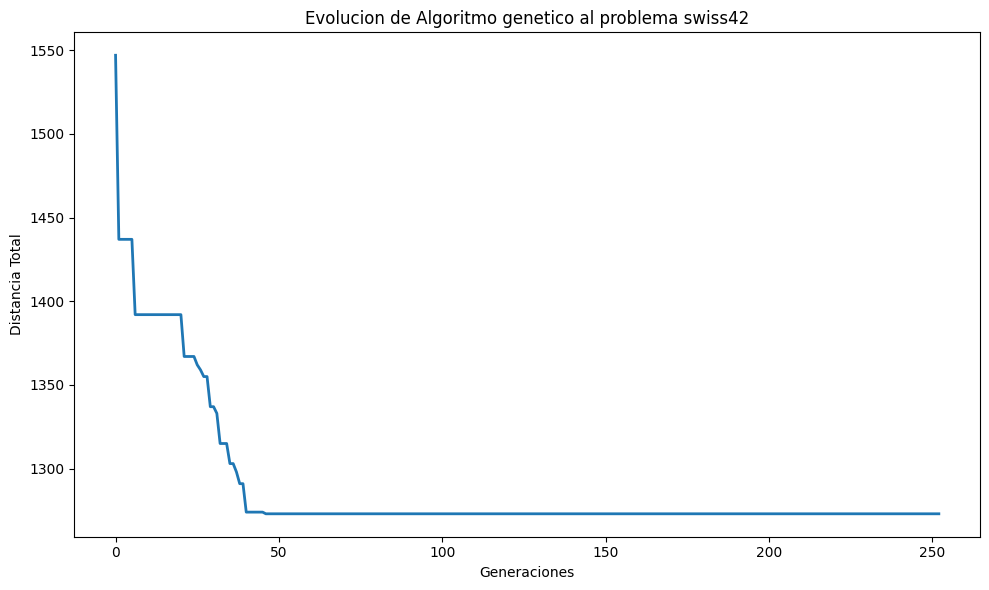

In [13]:
def algoritmo_genetico(
        problem: TSProblemType,
        N: int = 100,
        mutacion: float = .15,
        elitismo: float = .1,
        generaciones: int = 100,
        verbose: bool = False,
        dibujar_historico: bool = False,
):
    """
    Función principal del algoritmo genético
    :param problem: datos del problema
    :param N: Tamaño de la población
    :param mutacion: probabilidad de una mutación
    :param elitismo: porción de la mejor poblacion a mantener
    :param generaciones: nº de generaciones a generar para finalizar
    :return:
    """

    #Genera la poblacion inicial
    poblacion = generar_poblacion(problem, N)

    #Inicializamos valores para la mejor solucion
    mejor_solucion, mejor_distancia = Evaluar_Poblacion(poblacion, problem)

    # guardamos el historial de distancias para su posterior gratification
    distancias = [distancia_total(poblacion[0], problem), mejor_distancia]
    generacion = 0

    #Inciamos el ciclo de generaciones
    while generacion <= generaciones:

        #Cruce de la poblacion(incluye mutación)
        poblacion = Cruzar(poblacion, mutacion, problem)

        #Seleccionamos la población
        poblacion = Seleccionar(problem, poblacion, N, elitismo)

        #Evaluamos la nueva población
        solucion_actual, distancia_actual = Evaluar_Poblacion(
            poblacion, problem
        )
        distancias.append(distancia_actual)
        if verbose:
            print(
                "Generación #", generacion, "\nLa mejor solución es:", solucion_actual,
                "\ncon distancia ", distancia_actual, "\n"
            )

        # solo almacena la última mejor solucion
        if distancia_actual <= mejor_distancia:
            mejor_solucion = solucion_actual
            mejor_distancia = distancia_actual

        generacion += 1

    if dibujar_historico:
        x = range(len(distancias))
        plt.figure(figsize=(10, 6))
        plt.plot(
            x,
            distancias,
            color='#1f77b4', # Azul estándar y limpio
            linewidth=2,
            label='Mejor Distancia por Generación'
        )
        plt.title(
            f'Evolucion de Algoritmo genetico al problema {problem.name}'
        )
        plt.xlabel('Generaciones')
        plt.ylabel('Distancia Total')
        plt.tight_layout()
        plt.show()

    return mejor_solucion, mejor_distancia


sol, dis = algoritmo_genetico(
    problem=tsp_problem,
    N=500,
    mutacion=.3,
    elitismo=.40,
    generaciones=250,
    verbose=True,
    dibujar_historico=True
)

Representación en un grafo a partir de la matriz de distancias (Optimización de posiciones usando escalado multidimensional (MDS)

Multidimensional scaling problem(MDS):   https://en.wikipedia.org/wiki/Multidimensional_scaling


In [14]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import MDS  # Multidimensional Scaling o Escalado Multidimensional


def plot_tsp_solution(
        problem: TSProblemType,
        tsp_solution: SolutionType,
        title: str = "",
) -> None:
    """
    Dibuja el grafo de un TSP con las posiciones calculadas mediante MDS y muestra
    solo las aristas correspondientes a la solución del TSP.

    :param distance_matrix: np.ndarray, matriz de distancias entre nodos
    :param tsp_solution: list, lista de nodos en el orden de la solución del TSP
    """
    # Validaciones para verificar si el problema esta definido por
    # coordenadas en R2
    COORD_TYPES = {'EUC_2D', 'ATT', 'CEIL_2D', 'GEO', 'PSEUDO'}
    w_type = getattr(problem, 'edge_weight_type', None)
    has_coords = (w_type in COORD_TYPES) or (len(list(problem.node_coords)) > 0)

    if has_coords:
        pos = problem.node_coords
    else:
        distance_matrix = problem.edge_weights
        num_nodes = len(distance_matrix)
        # Usar MDS para calcular posiciones de los nodos
        mds = MDS(n_components=2, dissimilarity="precomputed", random_state=40)
        positions = mds.fit_transform(distance_matrix)
        # Convertir las posiciones en un diccionario para networkx
        pos = {i: positions[i] for i in range(num_nodes)}

    # Crear un subgrafo con las aristas del camino TSP
    TSP_G = nx.Graph()
    TSP_G.add_nodes_from(tsp_solution)
    path_len = len(tsp_solution)
    for i in range(path_len):
        u = tsp_solution[i]
        v = tsp_solution[(i + 1) % path_len]
        TSP_G.add_edge(u, v, weight=problem.get_weight(u, v))
    # Dibujar el grafo
    plt.figure(figsize=(8, 6))

    # Dibujar nodos
    nx.draw_networkx_nodes(TSP_G, pos, node_color='lightblue', node_size=250)

    # Dibujar las aristas del camino TSP
    nx.draw_networkx_edges(TSP_G, pos, edge_color='red', width=2)

    # Añadir etiquetas a los nodos y pesos de las aristas
    nx.draw_networkx_labels(TSP_G, pos, font_size=8, font_weight='bold')
    edge_labels = nx.get_edge_attributes(TSP_G, 'weight')
    nx.draw_networkx_edge_labels(TSP_G, pos, edge_labels=edge_labels,
                                 font_size=6)

    plt.title(
        f"Grafo TSP con solución específica de {problem.name}"
        f" Costo Total: {distancia_total(tsp_solution, problem)}"
        f"{f' - {title}' if title else ''}"
    )

    plt.show()


/home/**/03MIAR-Algoritmos-de-Optimizacion-2025/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


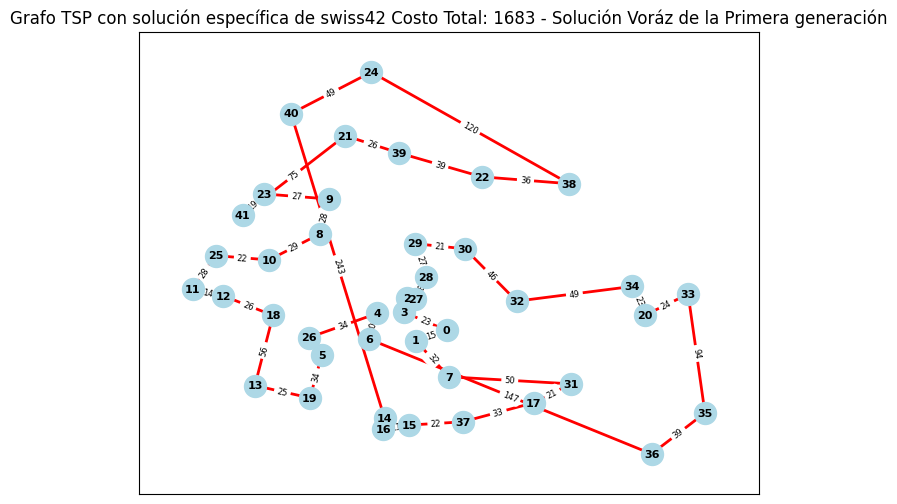

In [15]:
plot_tsp_solution(
    problem=tsp_problem,
    tsp_solution=generar_poblacion(tsp_problem, 500)[0],
    title="Solución Voráz de la Primera generación"
)

/home/**/03MIAR-Algoritmos-de-Optimizacion-2025/.venv/lib/python3.10/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


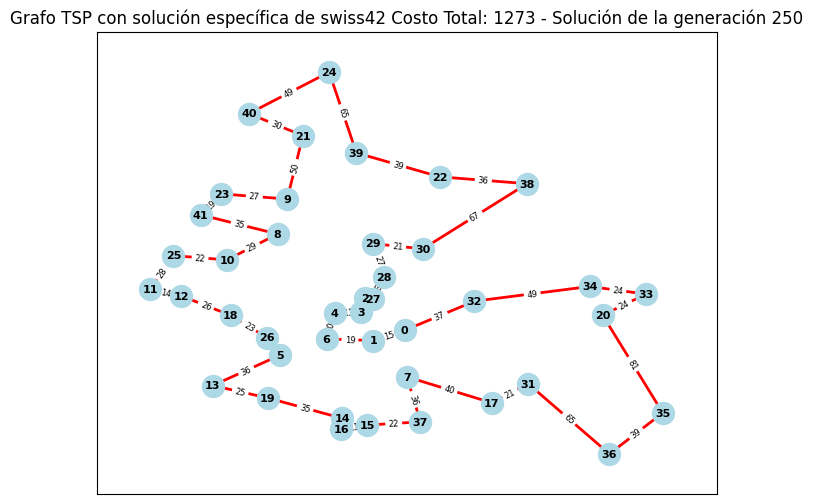

In [16]:
plot_tsp_solution(
    problem=tsp_problem,
    tsp_solution=sol,
    title="Solución de la generación 250"
)
display(HTML(
    f"Para el problema {tsp_problem.name}, la solución mínima más baja "
    f"encontrada hasta el momento es 1273, y el mínimo que se obtuvo con GA "
    f"es {dis}"
))

## Ejemplos con otros problemas _cortos_ de TSP


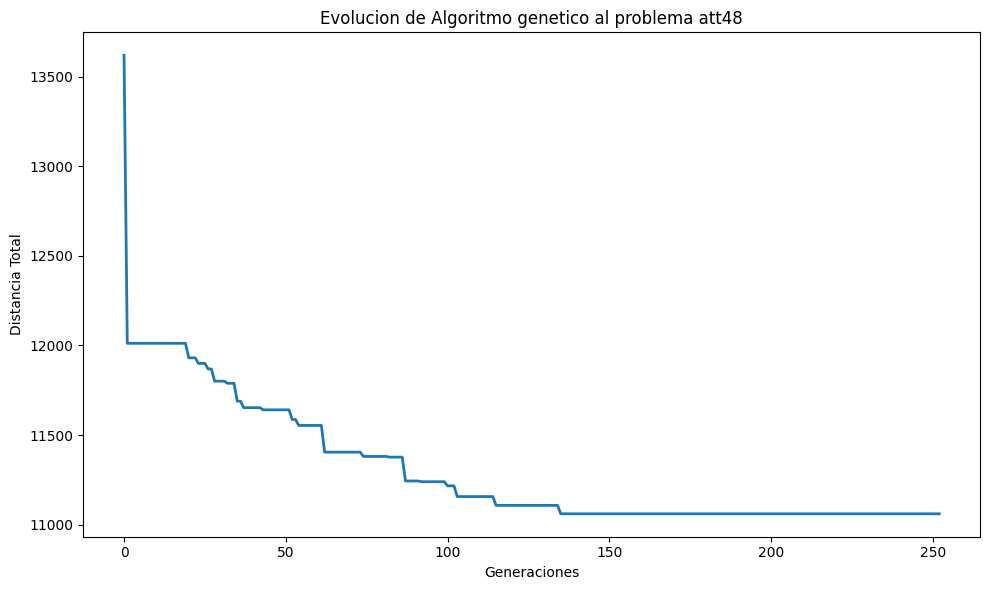

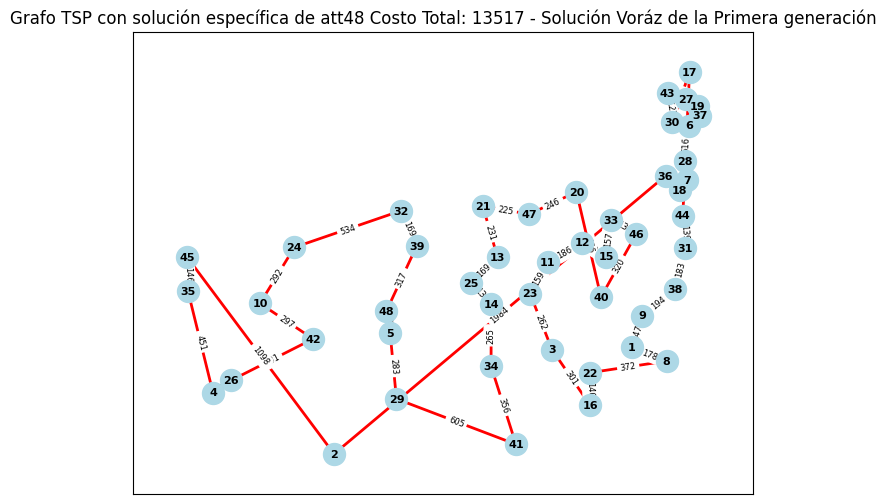

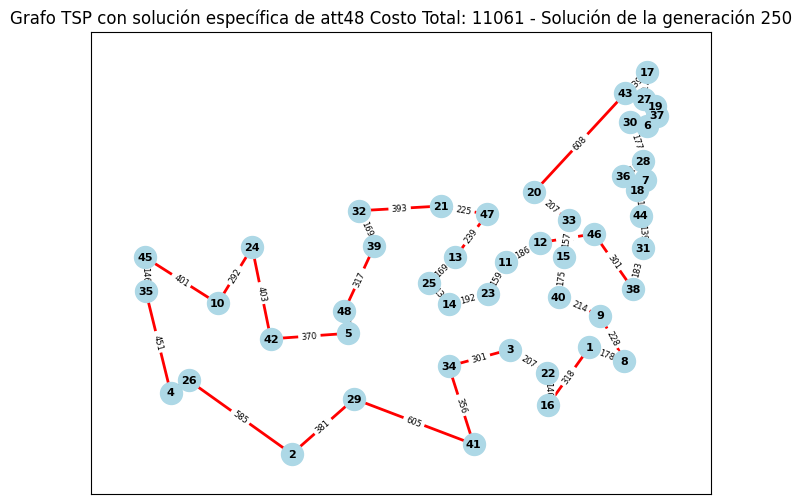

In [17]:
file = "att48.tsp"
download_tsp_file("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/att48.tsp", file)

att48_problem = tsplib95.load(file)
att48_problem.cached_nodes = list(att48_problem.get_nodes())

solucion_inicial_att48 = generar_poblacion(att48_problem, 500)[0]
mejor_solucion_att48, mejor_distancia = algoritmo_genetico(
    problem=att48_problem,
    N=500,
    mutacion=.3,
    elitismo=.40,
    generaciones=250,
    dibujar_historico=True
)
plot_tsp_solution(
    problem=att48_problem,
    tsp_solution=solucion_inicial_att48,
    title="Solución Voráz de la Primera generación"
)
plot_tsp_solution(
    problem=att48_problem,
    tsp_solution=mejor_solucion_att48,
    title="Solución de la generación 250"
)
display(HTML(
    f"Para el problema {att48_problem.name}, la solución mínima más baja "
    f"encontrada hasta el momento es 10628, y el mínimo que se obtuvo con GA "
    f"es {mejor_distancia}"
))


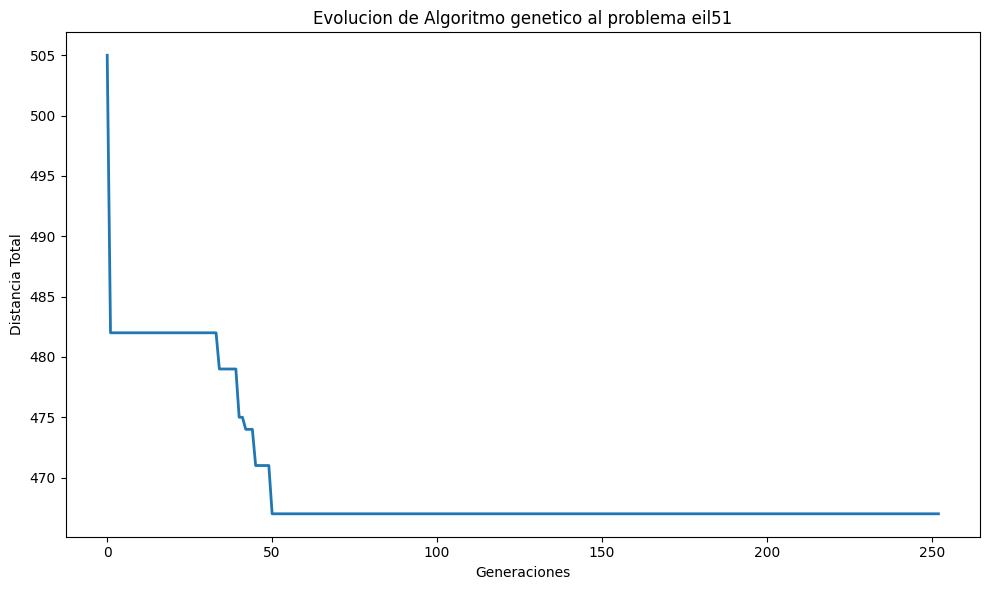

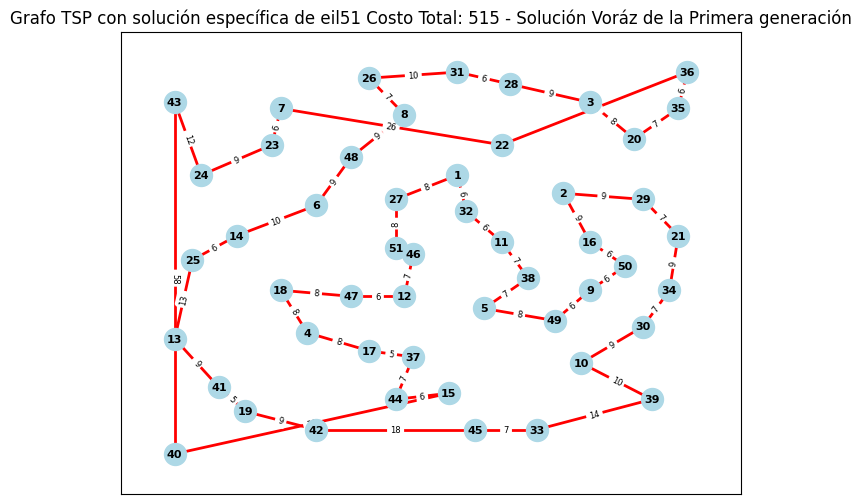

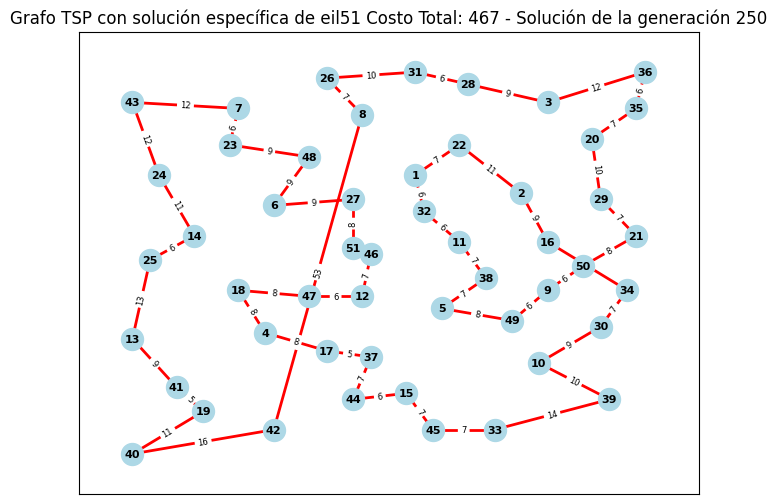

In [18]:
file = "eil51.tsp"
download_tsp_file("https://raw.githubusercontent.com/mastqe/tsplib/refs/heads/master/eil51.tsp", file)

eil51_problem = tsplib95.load(file)
eil51_problem.cached_nodes = list(eil51_problem.get_nodes())

solucion_inicial_eil51 = generar_poblacion(eil51_problem, 500)[0]
mejor_solucion_eil51, mejor_distancia = algoritmo_genetico(
    problem=eil51_problem,
    N=500,
    mutacion=.3,
    elitismo=.40,
    generaciones=250,
    dibujar_historico=True
)
plot_tsp_solution(
    problem=eil51_problem,
    tsp_solution=solucion_inicial_eil51,
    title="Solución Voráz de la Primera generación"
)
plot_tsp_solution(
    problem=eil51_problem,
    tsp_solution=mejor_solucion_eil51,
    title="Solución de la generación 250"
)
display(HTML(
    f"Para el problema {eil51_problem.name}, la solución mínima más baja "
    f"encontrada hasta el momento es 426, y el mínimo que se obtuvo con GA "
    f"es {mejor_distancia}"
))


# Bibliografia:
* [1] S. Rana y S. R. Srivastava, "Solving travelling salesman problem using improved genetic algorithm," Indian Journal of Science and Technology, vol. 10, no. 30, pp. 1–6, ago. 2017. doi: 10.17485/ijst/2017/v10i30/115512.
* [2] B. L. Miller y D. E. Goldberg, "Genetic algorithms, tournament selection, and the effects of noise," Complex Systems, vol. 9, no. 3, pp. 193–212, 1995.
* [3] mastqe, "tsplib/solutions," Repositorio de GitHub, [En línea]. Disponible: https://github.com/mastqe/tsplib/blob/master/solutions. [Accedido: 28-feb.-2026].